In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date


In [2]:
#import nvidia data from yfinance

START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

df = yf.download ('AMZN', START, TODAY)

[*********************100%***********************]  1 of 1 completed


In [3]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-08-30,172.779999,178.899994,172.600006,178.500000,178.500000,43429400
2024-09-03,177.550003,178.259995,175.259995,176.250000,176.250000,37735500
2024-09-04,174.479996,175.979996,172.539993,173.330002,173.330002,30309200
2024-09-05,175.000000,179.880005,175.000000,177.889999,177.889999,40170500
2024-09-06,177.240005,178.380005,171.160004,171.389999,171.389999,41179000


In [4]:
df = df.dropna()
print(df.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [5]:
#Moving Averages
df['SMA200'] = df['Close'].rolling(window=200).mean()
df['SMA50'] = df['Close'].rolling(window=50).mean()


In [6]:
# Bollinger Bands
df['BB_upper'] = df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std()
df['BB_lower'] = df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std()


In [7]:
#Calculate the price changes (difference between consecutive days)
delta = df['Close'].diff()

#Separate gains and losses
gain = delta.where(delta > 0, 0)  # Only positive price changes (gains)
loss = -delta.where(delta < 0, 0)  # Only negative price changes (losses as positive values)

#Calculate the rolling average of gains and losses (default window is 14 days)
window = 14
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

#Calculate the Relative Strength (RS)
rs = avg_gain / avg_loss

#Calculate the RSI using the formula
df['RSI'] = 100 - (100 / (1 + rs))

In [8]:
# Calculate the 12-period EMA
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()

# Calculate the 26-period EMA
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()

# Calculate MACD (the difference between 12-period EMA and 26-period EMA)
df['MACD'] = df['EMA12'] - df['EMA26']

# Calculate the 9-period EMA of MACD (Signal Line)
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [9]:
# Manually calculate the percentage returns
df['returns'] = (df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)

In [10]:
#Remove uncessary columns
df = df.drop('Adj Close', axis=1)

In [11]:
#Split target and features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA200', 'SMA50', 'RSI', 'MACD', 'Signal_Line', 'BB_upper', 'BB_lower', 'returns']
X = df[features]
y = df['Close']



In [12]:
# Handle any NaN values that might remain
X = X.dropna()
y = y[X.index]

In [13]:
from sklearn.preprocessing import MinMaxScaler

#Normalize data
scaler = MinMaxScaler()
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)



In [14]:
from sklearn.model_selection import train_test_split


#Split training and testing data 70/30
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.3, random_state=10, shuffle=False)

In [15]:
print(X_train.isnull().sum())  # Check for NaNs in training data
print(X_test.isnull().sum())   # Check for NaNs in test data


Open           0
High           0
Low            0
Close          0
Volume         0
SMA200         0
SMA50          0
RSI            0
MACD           0
Signal_Line    0
BB_upper       0
BB_lower       0
returns        0
dtype: int64
Open           0
High           0
Low            0
Close          0
Volume         0
SMA200         0
SMA50          0
RSI            0
MACD           0
Signal_Line    0
BB_upper       0
BB_lower       0
returns        0
dtype: int64


In [16]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

In [17]:
# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [18]:
# LSTM Model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

/Users/arnavjain/Desktop/Computer Science/stockprediction/myenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8435.9287 - val_loss: 28851.0156
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7874.0420 - val_loss: 13769.7002
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2255.5083 - val_loss: 101.5804
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 238.6531 - val_loss: 81.1031
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 232.0225 - val_loss: 71.0267
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 210.2548 - val_loss: 63.3366
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 192.4124 - val_loss: 59.2684
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 206.9881 - val_loss: 59.9145
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 176.6750 - val_loss: 47.6255
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 176.5885 - val_loss: 61.2215
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 200.9194 - val_loss: 41.7548
Epoch 12/50
44/44 ━━━━━━━━━━━━━

In [21]:
# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {loss}')





Test loss: 27.341352462768555


In [22]:
# Make predictions
predictions = model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step


In [23]:
predictions.shape

(672, 1)

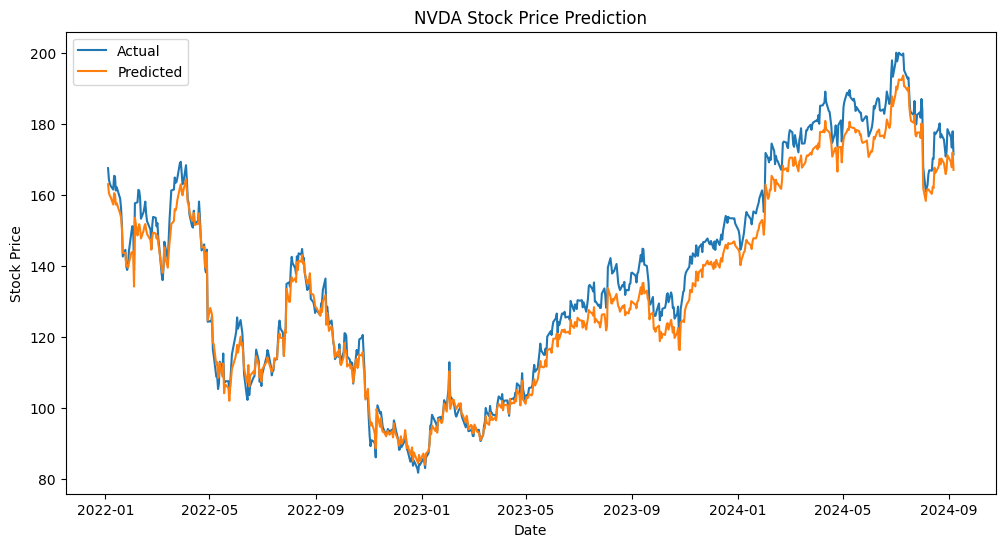

In [24]:
# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, predictions, label='Predicted')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [25]:
print(predictions[:10])  # Check the first 10 predictions


[[162.99605]
 [160.55873]
 [159.75685]
 [159.34943]
 [157.27673]
 [160.48903]
 [160.15506]
 [157.26843]
 [157.65419]
 [154.65506]]


NameError: name 'st' is not defined